In [15]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

from pathlib import Path
from tqdm import tqdm
from numpy import array
import sys
sys.path.append("..")
from core.utils import *
import atlas_mpl_style as ampl
import random
import mplhep as hep
hep.style.use("ATLAS")
import random

pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'
reweighting_vars = ['none','jet_nTracks', 'GBDT_newScore']
label_var = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5]#, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600]#, 800, 1000, 1200, 1500,2000]
bin_centers = 0.5 * (np.array(label_ptrange[:-1]) + np.array(label_ptrange[1:]))
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT score",
    "none":"No"
}
HistBins = {
    'jet_pt' : np.linspace(500, 2000, 61),
    'jet_eta' : np.linspace(-2.5, 2.5, 51), 
    'jet_nTracks' : np.linspace(0, 60, 61),
    'jet_trackWidth' : np.linspace(0, 0.4, 61),
    'jet_trackC1' : np.linspace(0, 0.4, 61),
    'jet_trackBDT' : np.linspace(-1.0, 1.0, 101),
    'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}

Map_gen={
"nominal": "Pythia",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia",
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [5]:
def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio
def Normalize_unumpy(array_unumpy, bin_width=1.0):
    area = np.sum(unumpy.nominal_values(array_unumpy)) * bin_width
    return array_unumpy / area

In [3]:
syst_total = joblib.load("/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/syst_uncertainties/syst_total.pkl")

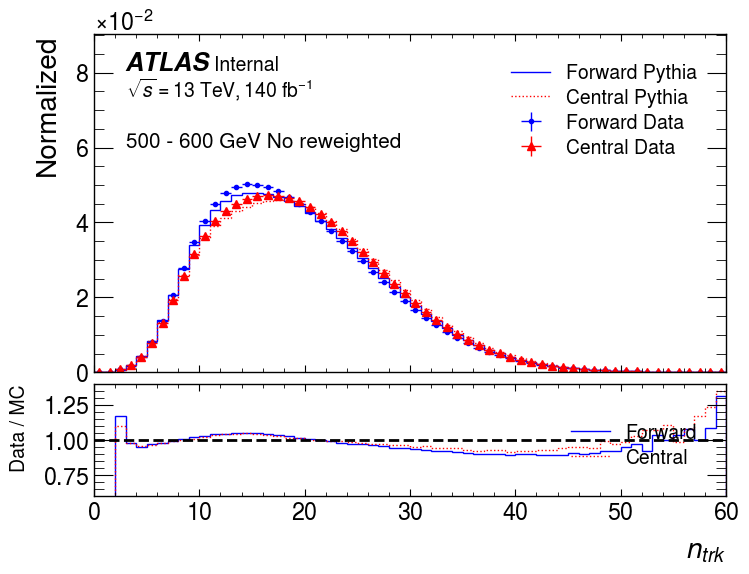

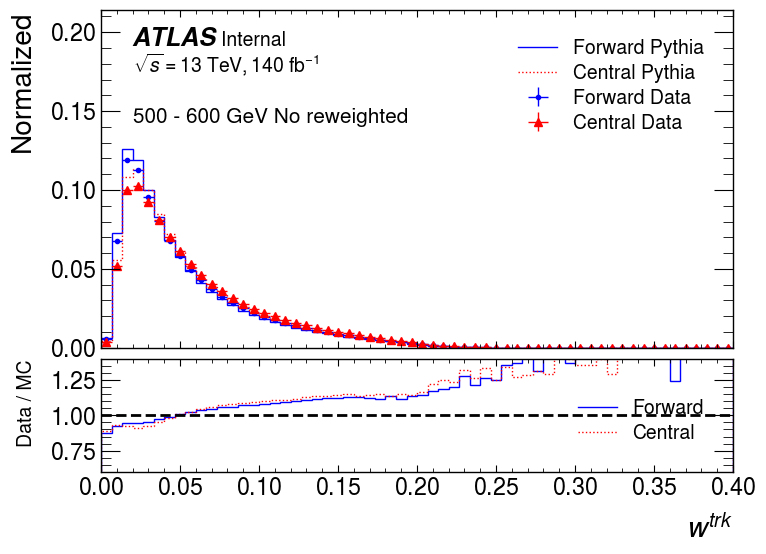

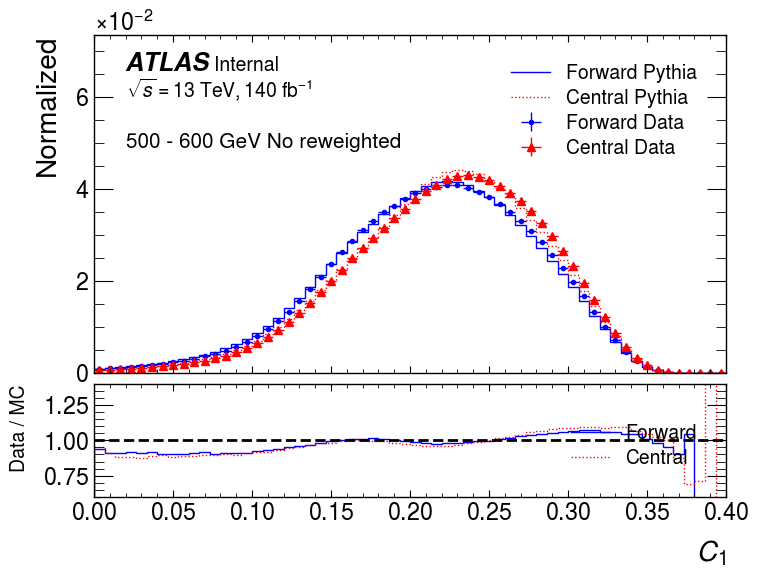

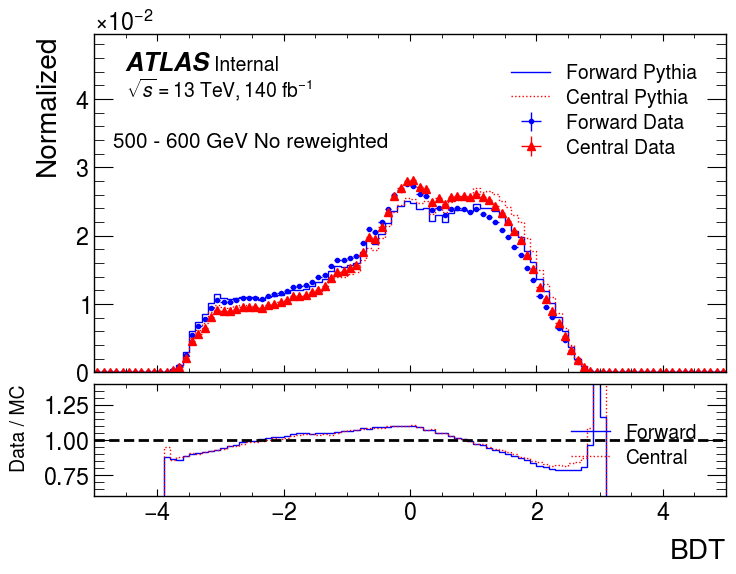

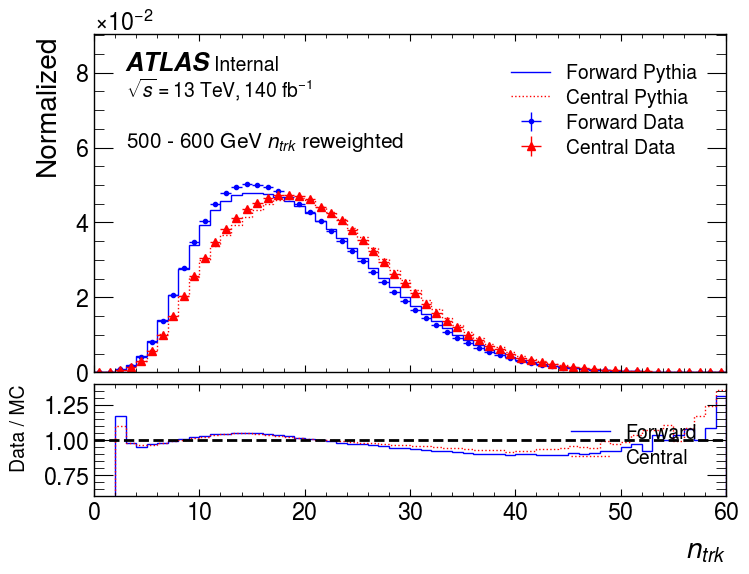

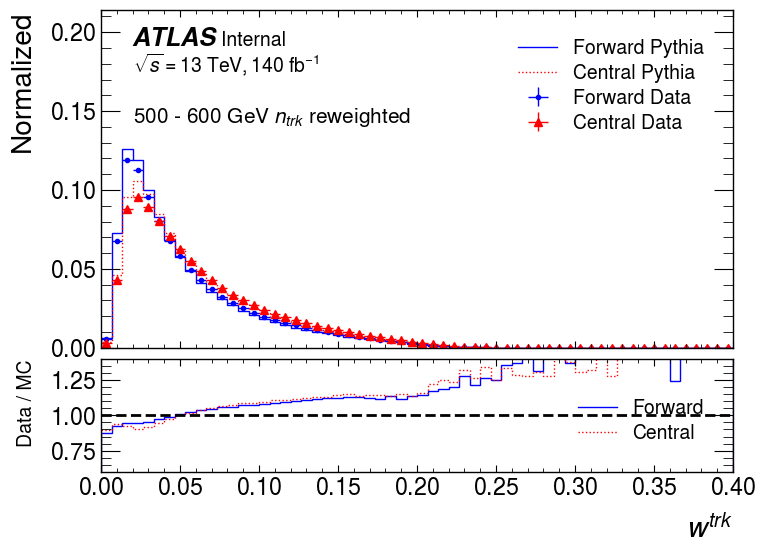

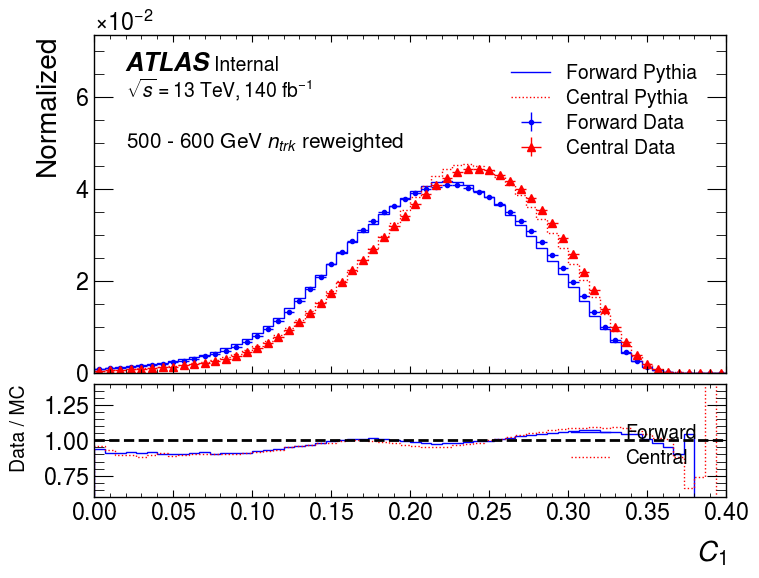

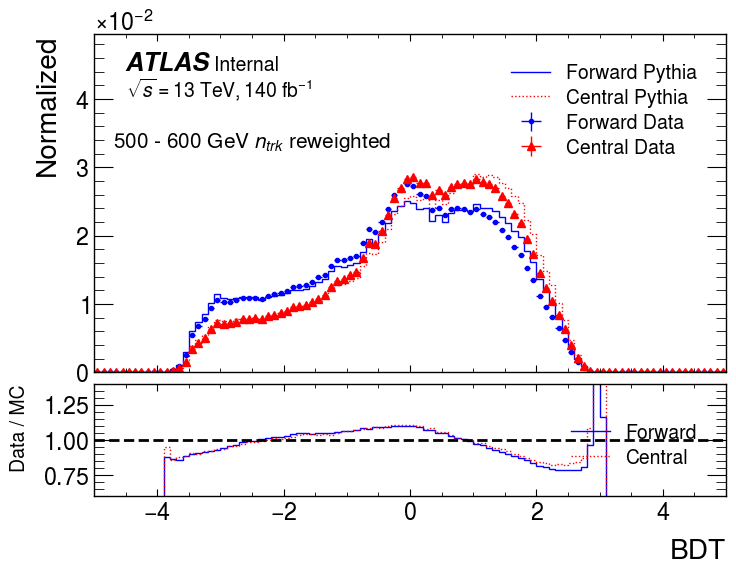

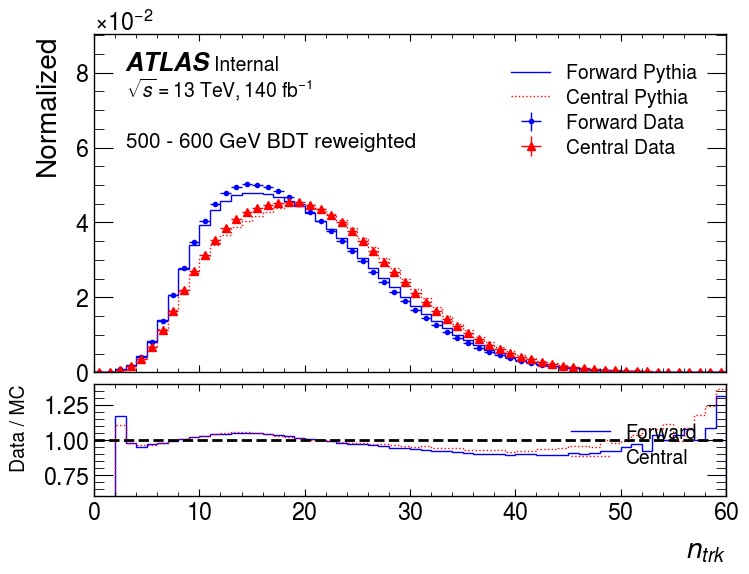

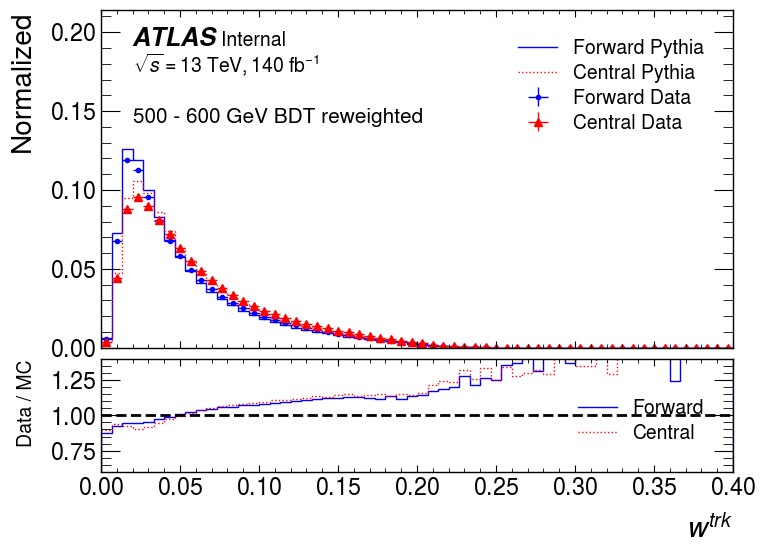

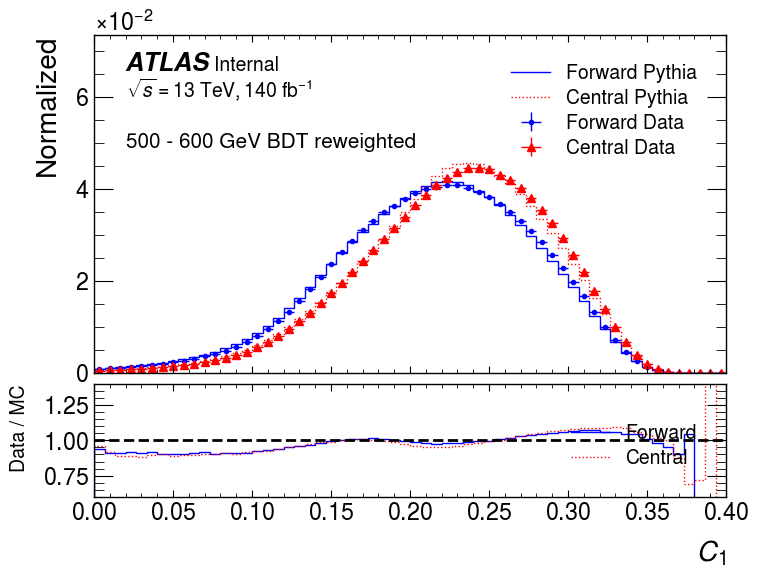

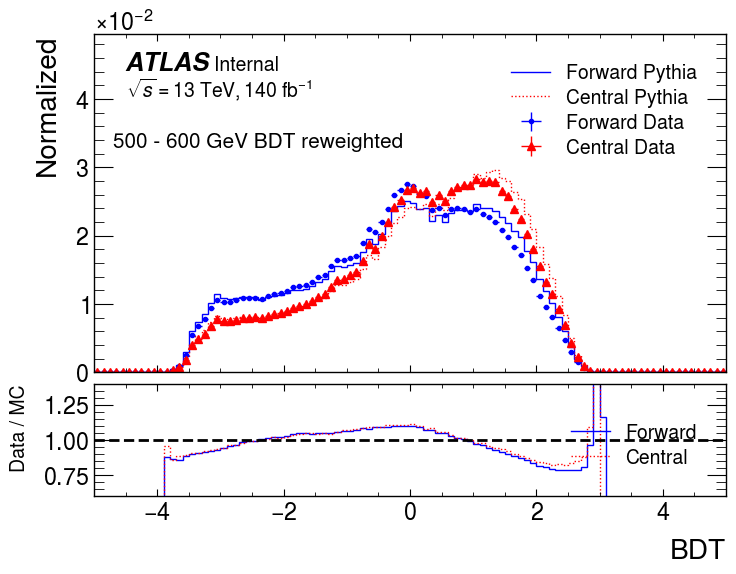

In [17]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for rvar in reweighting_vars:
    for i_pt, pt in enumerate(label_ptrange[:-1]):
        
        for i, syst in enumerate(syst_list):
            syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
            Extraction_Results[syst]= joblib.load(syst_path / f'{rvar}_Extraction_Results.pkl' )

            for var in label_var:
                bin_edges = HistBins[var]
                fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

                Extraction_var_pt =  Extraction_Results[syst][var][pt]
        
                Forward_MC= Normalize_unumpy(Extraction_var_pt['Forward_MC'])
                Central_MC= Normalize_unumpy(Extraction_var_pt['Central_MC'])
                Forward_Data= Normalize_unumpy(Extraction_var_pt['Forward_Data'] )
                Central_Data= Normalize_unumpy(Extraction_var_pt['Central_Data'])
                #print(unumpy.nominal_values(Forward_Data))

                hep.histplot(unumpy.nominal_values(Forward_MC),bins=bin_edges,ax=ax0,histtype='step',linestyle='-',color = 'blue', label = 'Forward Pythia')
                hep.histplot(unumpy.nominal_values(Central_MC),bins=bin_edges,ax=ax0,histtype='step',linestyle=':',color = 'red', label = 'Central Pythia')
                hep.histplot(unumpy.nominal_values(Forward_Data),bins=bin_edges,ax=ax0,histtype='errorbar',marker='.',xerr=True,yerr=unumpy.std_devs(Forward_Data),color = 'blue', label = 'Forward Data',markersize=6)
                hep.histplot(unumpy.nominal_values(Central_Data),bins=bin_edges,ax=ax0,histtype='errorbar',yerr=unumpy.std_devs(Central_Data),xerr=True,marker='^',color = 'red', label = 'Central Data',markersize=6)

                ratio_Forward = safe_array_divide_unumpy(numerator = Forward_Data, denominator = Forward_MC)
                ratio_Central = safe_array_divide_unumpy(numerator = Central_Data, denominator = Central_MC)
        
                hep.histplot(unumpy.nominal_values(ratio_Forward),bins=bin_edges,ax=ax1,histtype='step',linestyle='-',color = 'blue',label = 'Forward')
                hep.histplot(unumpy.nominal_values(ratio_Central),bins=bin_edges,ax=ax1,histtype='step',linestyle=':',color = 'red',label = 'Central')

                ax0.legend(loc='upper right')
                y_max = np.max(unumpy.nominal_values(Forward_Data))
                ytext=y_max*1.2
                ax0.set_ylabel("Normalized")
                ax0.text(bin_edges[3],ytext,f'{pt} - {label_ptrange[i_pt+1]} GeV {Map_var_title[rvar]} reweighted',fontsize=15)
                ax0.set_xlim(bin_edges[0], bin_edges[-1])
                ax0.set_ylim(0, y_max * 1.8)
                hep.atlas.label(label='Internal',data=True,ax=ax0,lumi=140)

                ax1.set_ylabel("Data / MC",fontsize=14)
                ax1.set_ylim(0.6, 1.4)
                ax1.legend(loc='lower right')
                ax1.set_xlabel(f"{Map_var_title[var]}")
                ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--', label='ratio = 1')


                fig.savefig(f"../FvsC/MCvsData_FvsC_{pt}_{rvar}_reweight_{var}_normed.pdf")

         